In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
# Using 16-bit precision to speed up calculations
from tensorflow.keras.mixed_precision import set_global_policy
set_global_policy('mixed_float16')


In [ ]:
IMG_SIZE = (160, 160) # mobilenetv2 best works for 160 160
BATCH_SIZE = 32
EPOCHS = 30


In [ ]:
# load datasets
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_dir = "/content/drive/MyDrive/AI/Datasets/train/train"
test_dir = "/content/drive/MyDrive/AI/Datasets/test/test"

train_dataset = image_dataset_from_directory(
    train_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical"
).prefetch(AUTOTUNE)

test_dataset = image_dataset_from_directory(
    test_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical"
).prefetch(AUTOTUNE)


Found 13914 files belonging to 10 classes.
Found 3483 files belonging to 10 classes.


In [ ]:
# load MobileNetV2 without top layers
base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(160, 160, 3))


In [ ]:
# Freeze all layers before fine-tuning
base_model.trainable = False

In [ ]:
# Adding layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
output = Dense(10, activation='softmax', dtype='float32')(x)


In [ ]:
model = Model(inputs=base_model.input, outputs=output)


In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [ ]:
# Callbacks
early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=3, min_lr=1e-6)


In [ ]:
history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=EPOCHS,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Epoch 1/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 1484s 3s/step - accuracy: 0.4118 - loss: 1.9428 - val_accuracy: 0.6974 - val_loss: 0.9495 - learning_rate: 1.0000e-04
Epoch 2/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 1217s 3s/step - accuracy: 0.6552 - loss: 1.0698 - val_accuracy: 0.7224 - val_loss: 0.8431 - learning_rate: 1.0000e-04
Epoch 3/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 1222s 3s/step - accuracy: 0.6950 - loss: 0.9435 - val_accuracy: 0.7376 - val_loss: 0.7944 - learning_rate: 1.0000e-04
Epoch 4/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 1225s 3s/step - accuracy: 0.7149 - loss: 0.8645 - val_accuracy: 0.7442 - val_loss: 0.7551 - learning_rate: 1.0000e-04
Epoch 5/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 1183s 3s/step - accuracy: 0.7311 - loss: 0.8131 - val_accuracy: 0.7499 - val_loss: 0.7311 - learning_rate: 1.0000e-04
Epoch 6/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 1183s 3s/step - accuracy: 0.7482 - loss: 0.7637 - val_accuracy: 0.7603 - val_loss: 0.7173 - learning_rate: 1.0000e-04
Epoch 7/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 1183s 3s/ste

In [ ]:
model.save("/content/drive/MyDrive/AI/models/mobilenetv2_material_classifier.h5")


In [ ]:
with open("/content/drive/MyDrive/AI/models/mobilenetv2_training_history.json", "w") as f:
    json.dump(history.history, f)


In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test Accuracy: {test_acc:.2f}")


109/109 ━━━━━━━━━━━━━━━━━━━━ 240s 2s/step - accuracy: 0.7948 - loss: 0.6392
Test Accuracy: 0.79


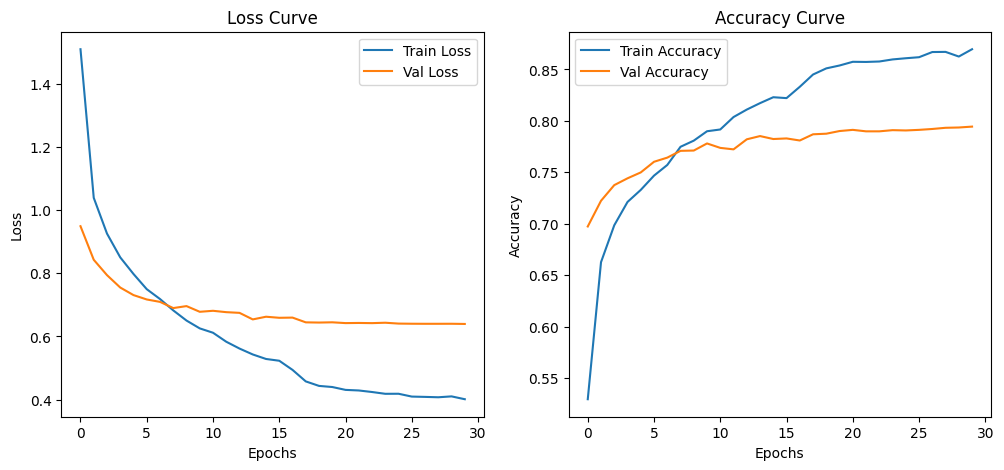

In [ ]:
# Побудова графіків навчання
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [ ]:
y_pred = model.predict(test_dataset)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.concatenate([y for x, y in test_dataset], axis=0)

109/109 ━━━━━━━━━━━━━━━━━━━━ 231s 2s/step


In [ ]:
print(y_true.shape, y_pred_classes.shape)

(3483, 10) (3483,)


Check model loading and metrics

Found 3483 images belonging to 10 classes.
109/109 ━━━━━━━━━━━━━━━━━━━━ 681s 6s/step
              precision    recall  f1-score   support

       brick       0.04      0.05      0.05       456
    concrete       0.41      0.03      0.06       623
        foam       0.00      0.00      0.00       204
   general_w       0.04      0.00      0.01       243
gypsum_board       0.12      0.01      0.01       332
       pipes       0.26      0.17      0.20       216
     plastic       0.11      0.20      0.14       211
       stone       0.06      0.00      0.01       247
        tile       0.30      0.11      0.16       321
        wood       0.23      0.80      0.36       630

    accuracy                           0.19      3483
   macro avg       0.16      0.14      0.10      3483
weighted avg       0.19      0.19      0.12      3483



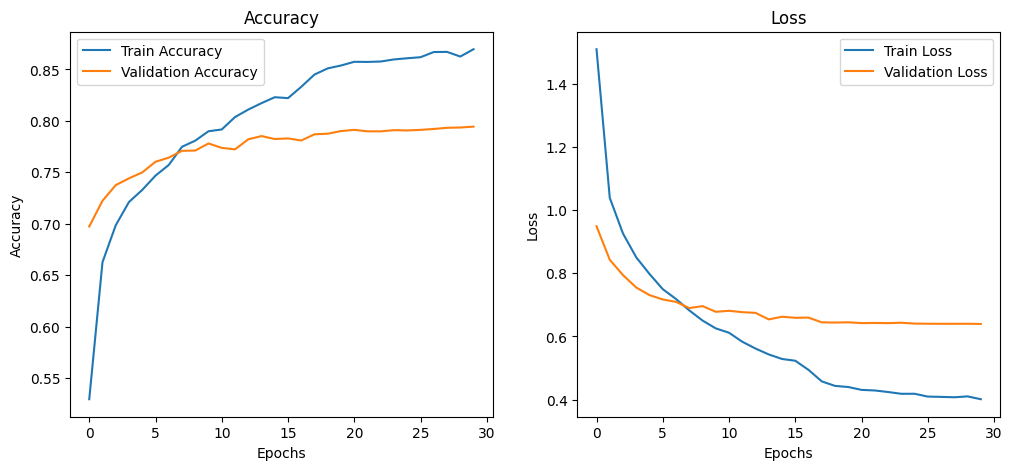

In [ ]:
import tensorflow as tf
import numpy as np
import json
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report

# Load model
model_path = "/content/drive/MyDrive/AI/models/mobilenetv2_material_classifier.keras"
model = tf.keras.models.load_model(model_path)

# Load history
history_path = "/content/drive/MyDrive/AI/models/mobilenetv2_training_history.json"
with open(history_path, "r") as f:
    history = json.load(f)

# Test data path
test_dir = "/content/drive/MyDrive/AI/Datasets/test/test"

# Генератор тестових даних
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(160, 160),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

y_true = test_generator.classes
class_indices = list(test_generator.class_indices.keys())

# pred
predictions = model.predict(test_generator)
y_pred = np.argmax(predictions, axis=1)

# classification report
report = classification_report(y_true, y_pred, target_names=class_indices)
print(report)

# loss/accuracy plots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Accuracy plot
axes[0].plot(history['accuracy'], label='Train Accuracy')
axes[0].plot(history['val_accuracy'], label='Validation Accuracy')
axes[0].set_title('Accuracy')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

# Loss plot
axes[1].plot(history['loss'], label='Train Loss')
axes[1].plot(history['val_loss'], label='Validation Loss')
axes[1].set_title('Loss')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend()

plt.show()